In [2]:
import torch

In [3]:
from torchvision import datasets

In [4]:
download_dir = "./dataset"

# Скачиваем обучающую выборку.
train_data = datasets.CIFAR10(root=download_dir, download=True, train=True)

# Скачиваем валидационную выборку.
val_data = datasets.CIFAR10(root=download_dir, download=True, train=False)

100.0%


In [5]:
# Объекты данных из обучающей выборки (50 000 цветных картинок размера 32 x 32).
x_train = torch.tensor(train_data.data)
x_train.shape

torch.Size([50000, 32, 32, 3])

In [6]:
# Предсказываемые величины для обучающей выборки (50 000 чисел от 0 до 9).
y_train = torch.tensor(train_data.targets)

print(y_train.shape, y_train.min(), y_train.max(), sep="\n")

torch.Size([50000])
tensor(0)
tensor(9)


In [7]:
# Сопоставление численных значений
#  (индексов в списке classes) реальным классам.
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
# Названия классов на русском языке.
classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

In [9]:
# Аналогично записываем x и y для валидационной выборки (10 000 примеров).
x_val = torch.tensor(val_data.data)
y_val = torch.tensor(val_data.targets)

print(x_val.shape, y_val.shape, sep="\n")

torch.Size([10000, 32, 32, 3])
torch.Size([10000])


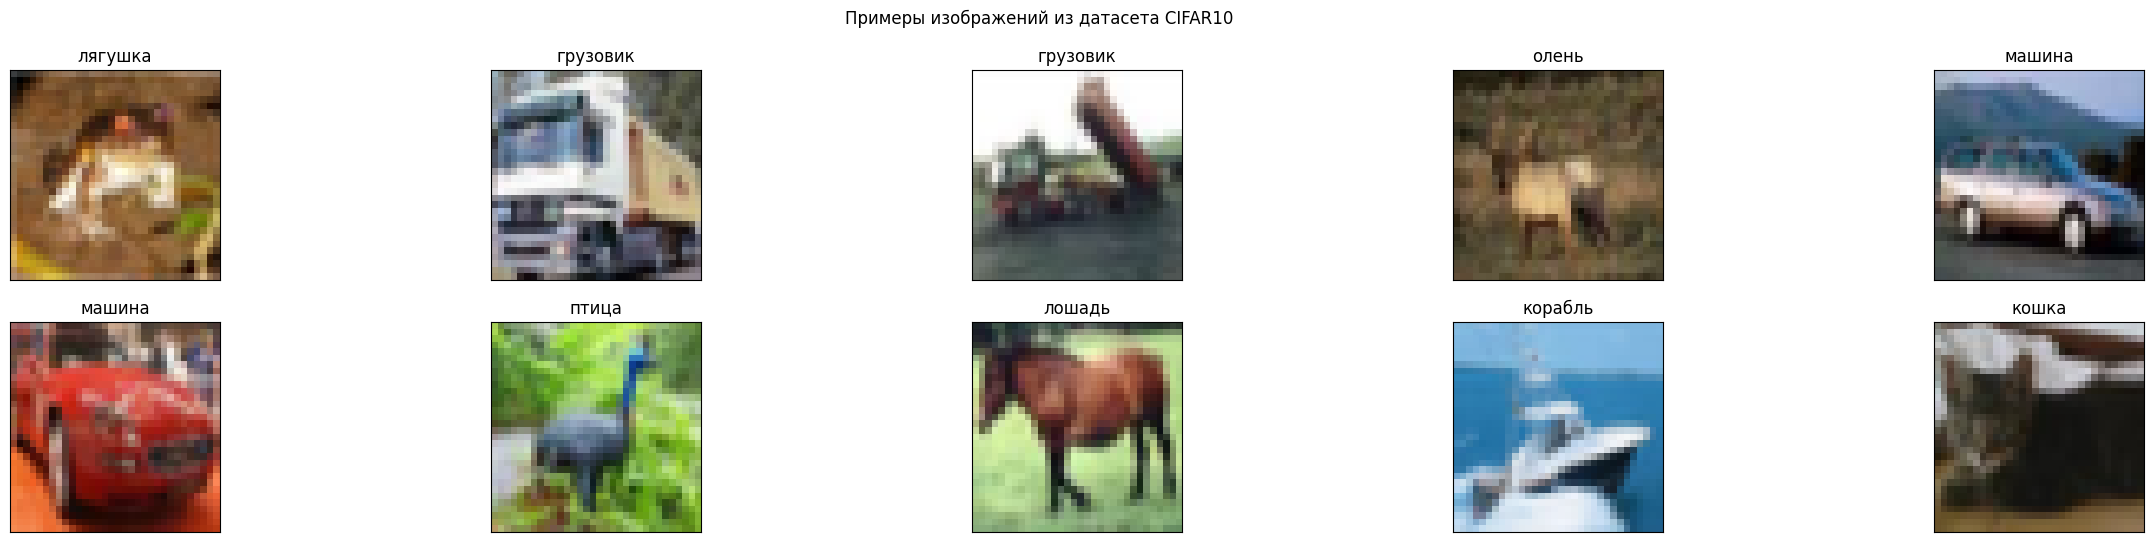

In [11]:
# Посмотрим на то, как выглядят картинки из датасета.

import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 3 * hh))
fig.suptitle("Примеры изображений из датасета CIFAR10")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes_ru[y])
plt.show()

In [12]:
# При обучении нейросетей нам будет удобнее работать
#  с пикселями, представленными в виде вещественных чисел.
x_train = torch.tensor(train_data.data) / 255.
x_val = torch.tensor(val_data.data) / 255.

print(x_train.min(), x_train.max(), x_train.dtype, sep="\n")

tensor(0.)
tensor(1.)
torch.float32


In [13]:
# Свёртка.
conv_layer = torch.nn.Conv2d(
    in_channels=3,         # Число каналов на входе.
    out_channels=10,       # Число каналов на выходе.
    kernel_size=3,         # Размер ядра.
    padding=1,             # Размер паддинга (1 элемент добавляется с каждой стороны).
    padding_mode="zeros",  # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
    stride=1,              # Stride - 1 (смотрим на каждую позицию).
    dilation=1,            # Dilation - 1 (ядро прикладывается к фрагменту изображения без пропусков).
)

# Применяется слой свёртки к группе картинок в формате bs x c x h x w.
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x = conv_layer(x)

print(f"Размер после свёртки: {x.shape}")

Размер до свёртки: torch.Size([2, 3, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])


In [14]:
# Residual connection.
conv_layer_2 = torch.nn.Conv2d(
    in_channels=10,
    out_channels=10,
    kernel_size=3,
    padding=1,
)

x = torch.rand(2, 10, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x2 = conv_layer_2(x)

print(f"Размер после свёртки: {x2.shape}")

h = x + x2

Размер до свёртки: torch.Size([2, 10, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])


In [15]:
# Residual connection в ситуации, когда вход и выход
#  имеют разные количества каналов.
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x2 = conv_layer(x)

print(f"Размер после свёртки: {x2.shape}")

# Вариант 1: объединяем (конкатенируем) тензоры вдоль размерности каналов.
h = torch.cat([x, x2], dim=1)

print(f"Размер выхода при конкатенации: {h.shape}")


# Вариант 2: применяем свёртку с ядром 1x1, чтобы привести
#  исходный тензор к состоянию, когда число каналов
#  в нём совпадает с числом каналов в выходном тензоре.
conv_1_1 = torch.nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=1,  # Ищем шаблоны размера 1x1xc
)
h = conv_1_1(x) + x2

print(f"Размер выхода при сумме через 1x1 свёртку: {h.shape}")

Размер до свёртки: torch.Size([2, 3, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])
Размер выхода при конкатенации: torch.Size([2, 13, 32, 32])
Размер выхода при сумме через 1x1 свёртку: torch.Size([2, 10, 32, 32])


In [16]:
# Напишем свой блок свёртки с residual connection.

class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        activation=torch.nn.ReLU,  # Класс функции активации.
    ):
        super().__init__()

        # Функция активации для нелинейности.
        self.activation = activation()

        # TODO:
        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        #  (считаем, что размер ядра всегда нечётный).
        padding_size = (kernel_size-1)//2

        # TODO:
        # Операция свёртки.
        # Создайте сверточный слой с помощью класса torch.nn.Conv2d
        # укажите количество каналов на входе и выходе, размер ядра,
        # размер паддинга и режим его выполнения (заполнение нулями)
        self.conv = torch.nn.Conv2d(input_c, output_c, kernel_size, padding=padding_size)

        # Если числа каналов у входа и выхода различаются,
        if input_c != output_c:
            # ТОDO:
            # то будем делать свёртку с ядром размера 1.
            self.correct_channels = torch.nn.Conv2d(input_c, output_c, 1)
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.

    # Прямой проход.
    def forward(self, x):
        # ТОDO:
        # реализуйте прямой проход
        return self.activation(self.conv(x) + self.correct_channels(x))

In [17]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 10 каналов на выходе,
# размер ядра свертки равен 3 и
# в качестве функции активации используется ReLU

rb = ResidualBlock(3, 10, 3)

In [18]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 10 каналов на входе, 10 каналов на выходе и
# размер ядра свертки равен 3 и
# в качестве функции активации используется "Гиперболический тангенс"

rb2 = ResidualBlock(3, 10, 3, torch.nn.Tanh)

In [19]:
# Соберём вручную простую свёрточную нейросеть,
#  используя написанный ранее residual block.
from collections import OrderedDict

conv_layers = [
    (
        "residual_block_1",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 8 каналов на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU
       ResidualBlock(3, 8, 3)
    ),
    (
        "residual_block_2",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 8 каналов на входе, 16 каналов на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU
       ResidualBlock(8, 16, 3)
    ),
    (
        "pooling",
        torch.nn.MaxPool2d(kernel_size=2),
    ),
    (
        "residual_block_3",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 16 каналов на входе, 32 канала на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU
       ResidualBlock(16, 32, 3)
    ),
]

conv_model = torch.nn.Sequential(OrderedDict(conv_layers))
conv_model

Sequential(
  (residual_block_1): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (residual_block_2): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (residual_block_3): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [20]:
# С помощью функции max в torch можно сделать MaxPooling.
h = torch.rand(2, 3)

print(h, h.max(1), h.max(1).values.shape, h[0, :], h[1, :], sep="\n\n")

tensor([[0.1036, 0.9273, 0.9131],
        [0.4760, 0.8977, 0.6753]])

torch.return_types.max(
values=tensor([0.9273, 0.8977]),
indices=tensor([1, 1]))

torch.Size([2])

tensor([0.1036, 0.9273, 0.9131])

tensor([0.4760, 0.8977, 0.6753])


In [21]:
# Теперь соберём вручную классификатор.
lin_layers = [
    (
        "linear_1",
        # TODO:
        # Сделайте полносвязный слой у которого 32 канала на входе, 16 каналов на выходе,
        # создайте для этого экземпляр класса torch.nn.Linear
        torch.nn.Linear(32, 16)
    ),
    (
        "linear_activation_1",
        # TODO:
        # в качестве функции активации используется ReLU
        torch.nn.ReLU()
    ),
    (
        "linear_2",
        # TODO:
        # Сделайте полносвязный слой у которого 16 каналов на входе, 10 каналов на выходе,
        # создайте для этого экземпляр класса torch.nn.Linear
        torch.nn.Linear(16, 10)
    ),
    (
        "softmax",
        torch.nn.Softmax(-1),
    ),
]

lin_model = torch.nn.Sequential(OrderedDict(lin_layers))
lin_model

Sequential(
  (linear_1): Linear(in_features=32, out_features=16, bias=True)
  (linear_activation_1): ReLU()
  (linear_2): Linear(in_features=16, out_features=10, bias=True)
  (softmax): Softmax(dim=-1)
)

In [22]:
# Посмотрим на примере.
x = torch.rand(2, 3, 32, 32)

print(f"Изначальный размер: {x.shape}")

# Применяем свёрточные слои.
x = conv_model(x)

print(f"После свёрток: {x.shape}")

# Сделаем операцию GlobalMaxPooling.
x = x.max(-1).values.max(-1).values

print(f"После глобального пулинга: {x.shape}")

# Применяем классификатор.
x = lin_model(x)

print(f"После классификатора: {x.shape}\n")

print(x, x.sum(1), sep="\n\n")

Изначальный размер: torch.Size([2, 3, 32, 32])
После свёрток: torch.Size([2, 32, 16, 16])
После глобального пулинга: torch.Size([2, 32])
После классификатора: torch.Size([2, 10])

tensor([[0.1195, 0.0994, 0.1145, 0.0593, 0.0743, 0.0977, 0.1246, 0.0969, 0.0965,
         0.1175],
        [0.1195, 0.1009, 0.1153, 0.0590, 0.0743, 0.0970, 0.1227, 0.0968, 0.0961,
         0.1184]], grad_fn=<SoftmaxBackward0>)

tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)


In [23]:
# Повторим задание свёрточной нейронной сети на основе residual block,
# но в более общем виде при помощи обёртки torch.nn.Module.
IMG_SIZE = 32

class ResidualModel(torch.nn.Module):
    def __init__(
        self,
        out_size,                    # Число классов.
        residual_sizes,              # Задаём список троек: количество residual-блоков,
                                     #  число каналов и размер ядра в каждом таком блоке.
        linear_sizes,                # Список размеров линейных слоёв в финальном классификаторе.
        activation = torch.nn.ReLU,  # Какую функцию активации использовать.
        flatten = True,              # Использовать Flatten или GlobalPooling.
    ):
        super().__init__()
        self.flatten = flatten

        # Собираем все свёрточные слои в один блок.
        conv_layers = []

        current_c = 3
        for group_index, (num_residual, out_channels, kernel_size) in enumerate(residual_sizes):
            for residual_index in range(num_residual):
                conv_layers.append((
                    # Добавляем несколько residual-блоков для каждой группы.
                    f"residual_{group_index}_{residual_index}",
                    ResidualBlock(
                        input_c = current_c if residual_index == 0 else out_channels,
                        output_c = out_channels,
                        kernel_size = kernel_size,
                        activation = activation,
                    ),
                ))
            current_c = out_channels
            if group_index < len(residual_sizes) - 1:
                conv_layers.append((
                    # В конце группы добавляем один pooling-слой,
                    # если это не последняя группа.
                    f"pooling_{group_index}",
                    torch.nn.AvgPool2d(2),
                ))

        self.conv_part = torch.nn.Sequential(OrderedDict(conv_layers))

        # Собираем все линейные слои во второй блок.
        out_c = residual_sizes[-1][1]
        final_size = IMG_SIZE // 2 ** (len(residual_sizes) - 1)
        clf_in_size = (out_c * final_size**2) if flatten else out_c

        linear_sizes = [clf_in_size, *linear_sizes, out_size]

        clf_layers = []

        for i, (from_size, to_size) in enumerate(zip(linear_sizes[:-1], linear_sizes[1:])):
            clf_layers.append((f"linear_{i}", torch.nn.Linear(from_size, to_size)))
            if i < len(linear_sizes) - 2:
                clf_layers.append((f"act_{i}", activation()))
            else:
                clf_layers.append(("log_softmax", torch.nn.LogSoftmax(-1)))

        self.clf_part = torch.nn.Sequential(OrderedDict(clf_layers))

    def forward(self, x):  # input (bs x h x w x c_in)
        x = x.permute((0, 3, 1, 2))  # (bs x c_in x h x w)

        x = self.conv_part(x)  # bs x c_out x h' x w'

        if self.flatten:
            # Операция Flatten.
            x = x.reshape(x.shape[0], -1)  # bs x (c_out * h' * w')
        else:
            # Операция GlobalMaxPooling.
            x = x.max(-1).values.max(-1).values  # bs x c_out


        x = self.clf_part(x)  # bs x 10

        return x




In [24]:
def print_num_params(model):
    # Считаем общее количество обучаемых весов в модели.
    sum_params_size = 0
    for name, param in model.named_parameters():
        param_size = param.numel()
        print("{:<46} ~ {:<14} ~ {}".format(name, str(list(param.shape)), param_size))
        sum_params_size += param_size
    print(f"Общее число параметров ~ {sum_params_size}")


In [25]:
model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=True,
)

model

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_1_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_2_0): Re

In [26]:
print_num_params(model)

conv_part.residual_0_0.conv.weight             ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv.bias               ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.conv.weight             ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv.bias               ~ [8]            ~ 8
conv_part.residual_1_0.conv.weight             ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv.bias               ~ [16]           ~ 16
conv_part.residual_1_0.correct_channels.weight ~ [16, 8, 1, 1]  ~ 128
conv_part.residual_1_0.correct_channels.bias   ~ [16]           ~ 16
conv_part.residual_1_1.conv.weight             ~ [16, 16, 3, 3] ~ 2304
conv_part.residual_1_1.conv.bias               ~ [16]           ~ 16
conv_part.residual_2_0.conv.weight             ~ [32, 16, 3, 3] ~ 4608
conv_part.residual_2_0.conv.bias               ~ [32]           ~ 32
conv_part.residual_2_0.corre

In [27]:
# TODO:
# Используя созданный ранее класс ResidualModel,
# создайте нейронную сеть с такой же архитектурой как и ранее,
# но использующую глобальный MaxPooling перед применением полносвязных слоев 

model = ResidualModel(10, [(2, 8, 3), (2, 16, 3), (2, 32, 3), (2, 32, 3)], [32], flatten=False)

model

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_1_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_2_0): Re

In [28]:
# TODO:
# выведите подробную информацию о коичечестве параметров этой неросети 

for name, module in model.named_children():
    print(name, sum(p.numel() for p in module.parameters()))

conv_part 37400
clf_part 1386


In [29]:
import matplotlib.pyplot as plt

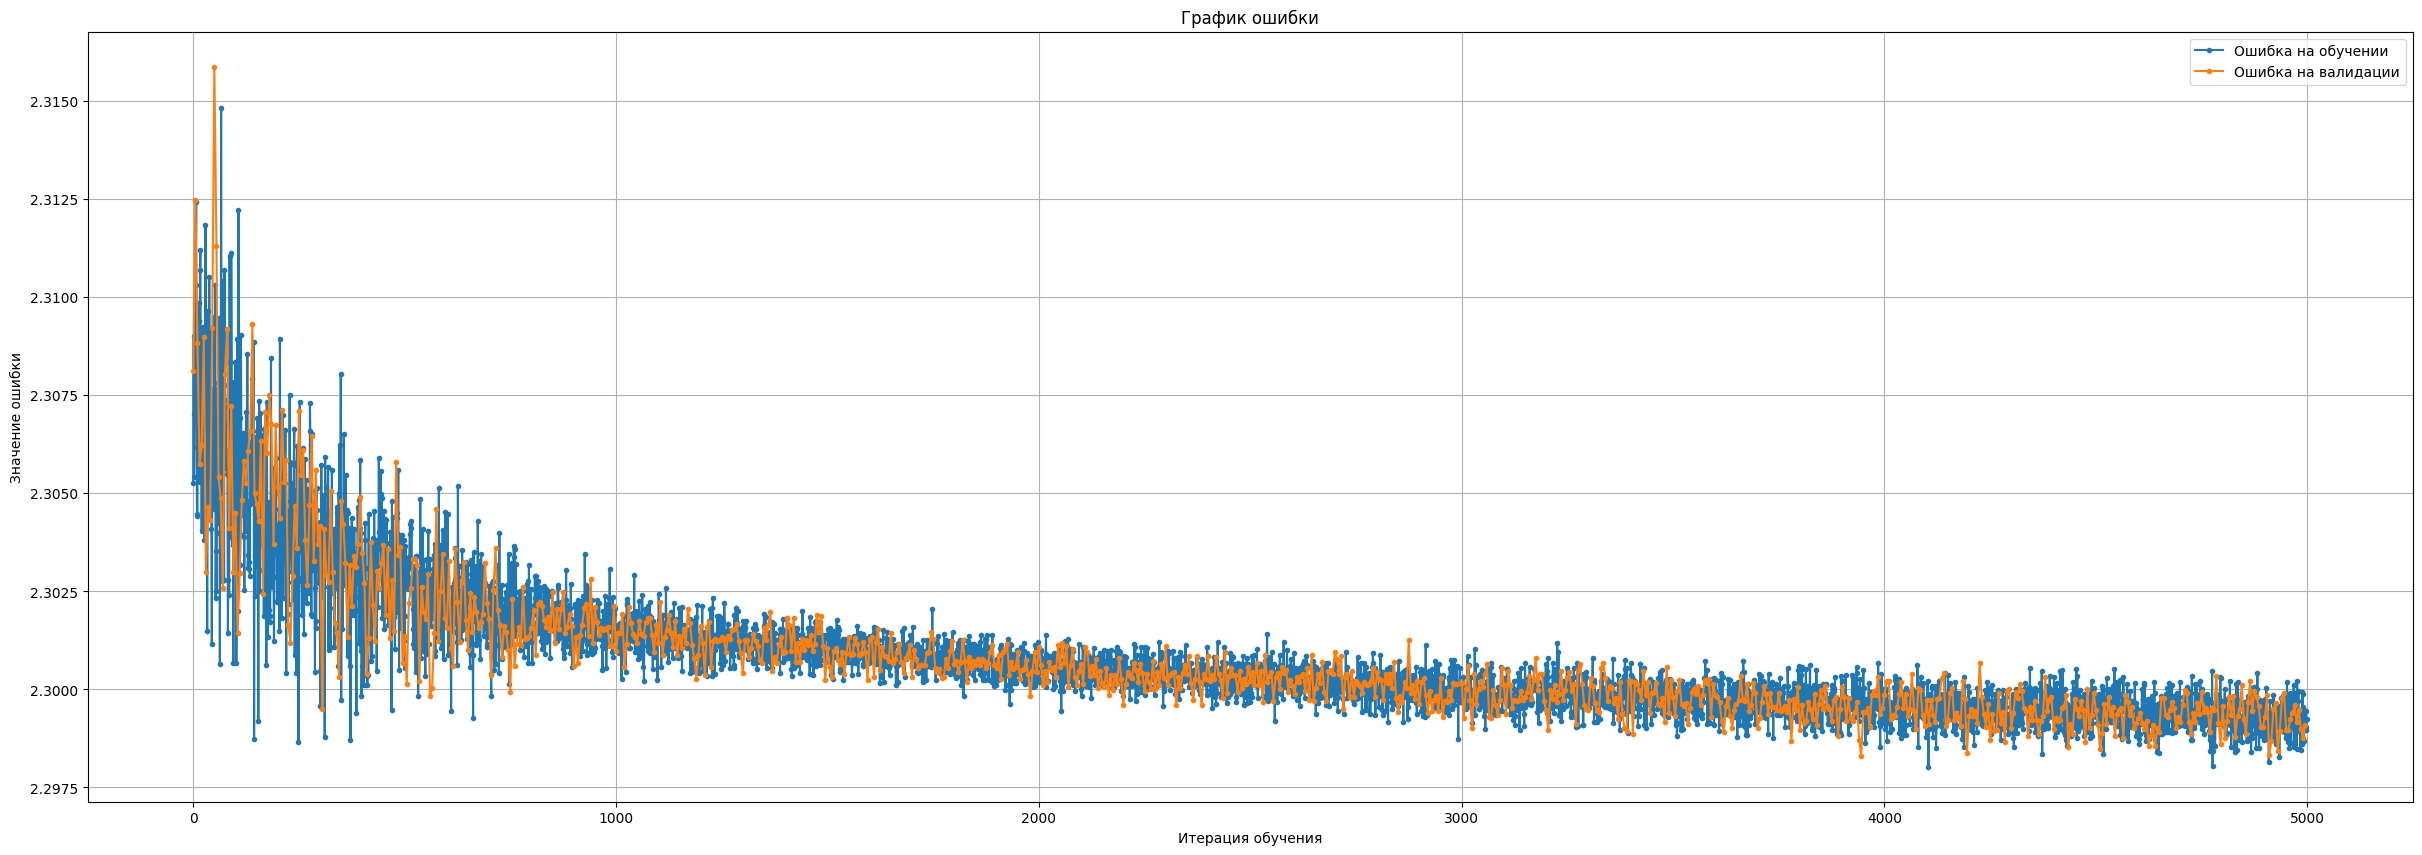

In [30]:
# Реализуем цикл обучения модели.
# ВАЖНО, что обучение модели с параметрами, приведёнными ниже, работает очень долго.

from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера
#  или виртуальной машины, если есть такая возможность.
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5000
batch_size = 1000
val_every = 5

model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=False,
).to(dtype=x_train.dtype, device=device)  # Важно, чтобы все тензоры были одного типа и на одном устройстве.

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
)

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска, который
#  в данном случае мы будем постепенно уменьшать с течением времени.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.NLLLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    # Будем на каждой итерации обучения брать не все 50 000 картинок,
    #  а лишь случайные batch_size из них.
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])

    pred = model(x_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Каждые val_every итераций считаем значение loss на валидационной выборке.
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 100 итераций рисуем графики loss.
    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

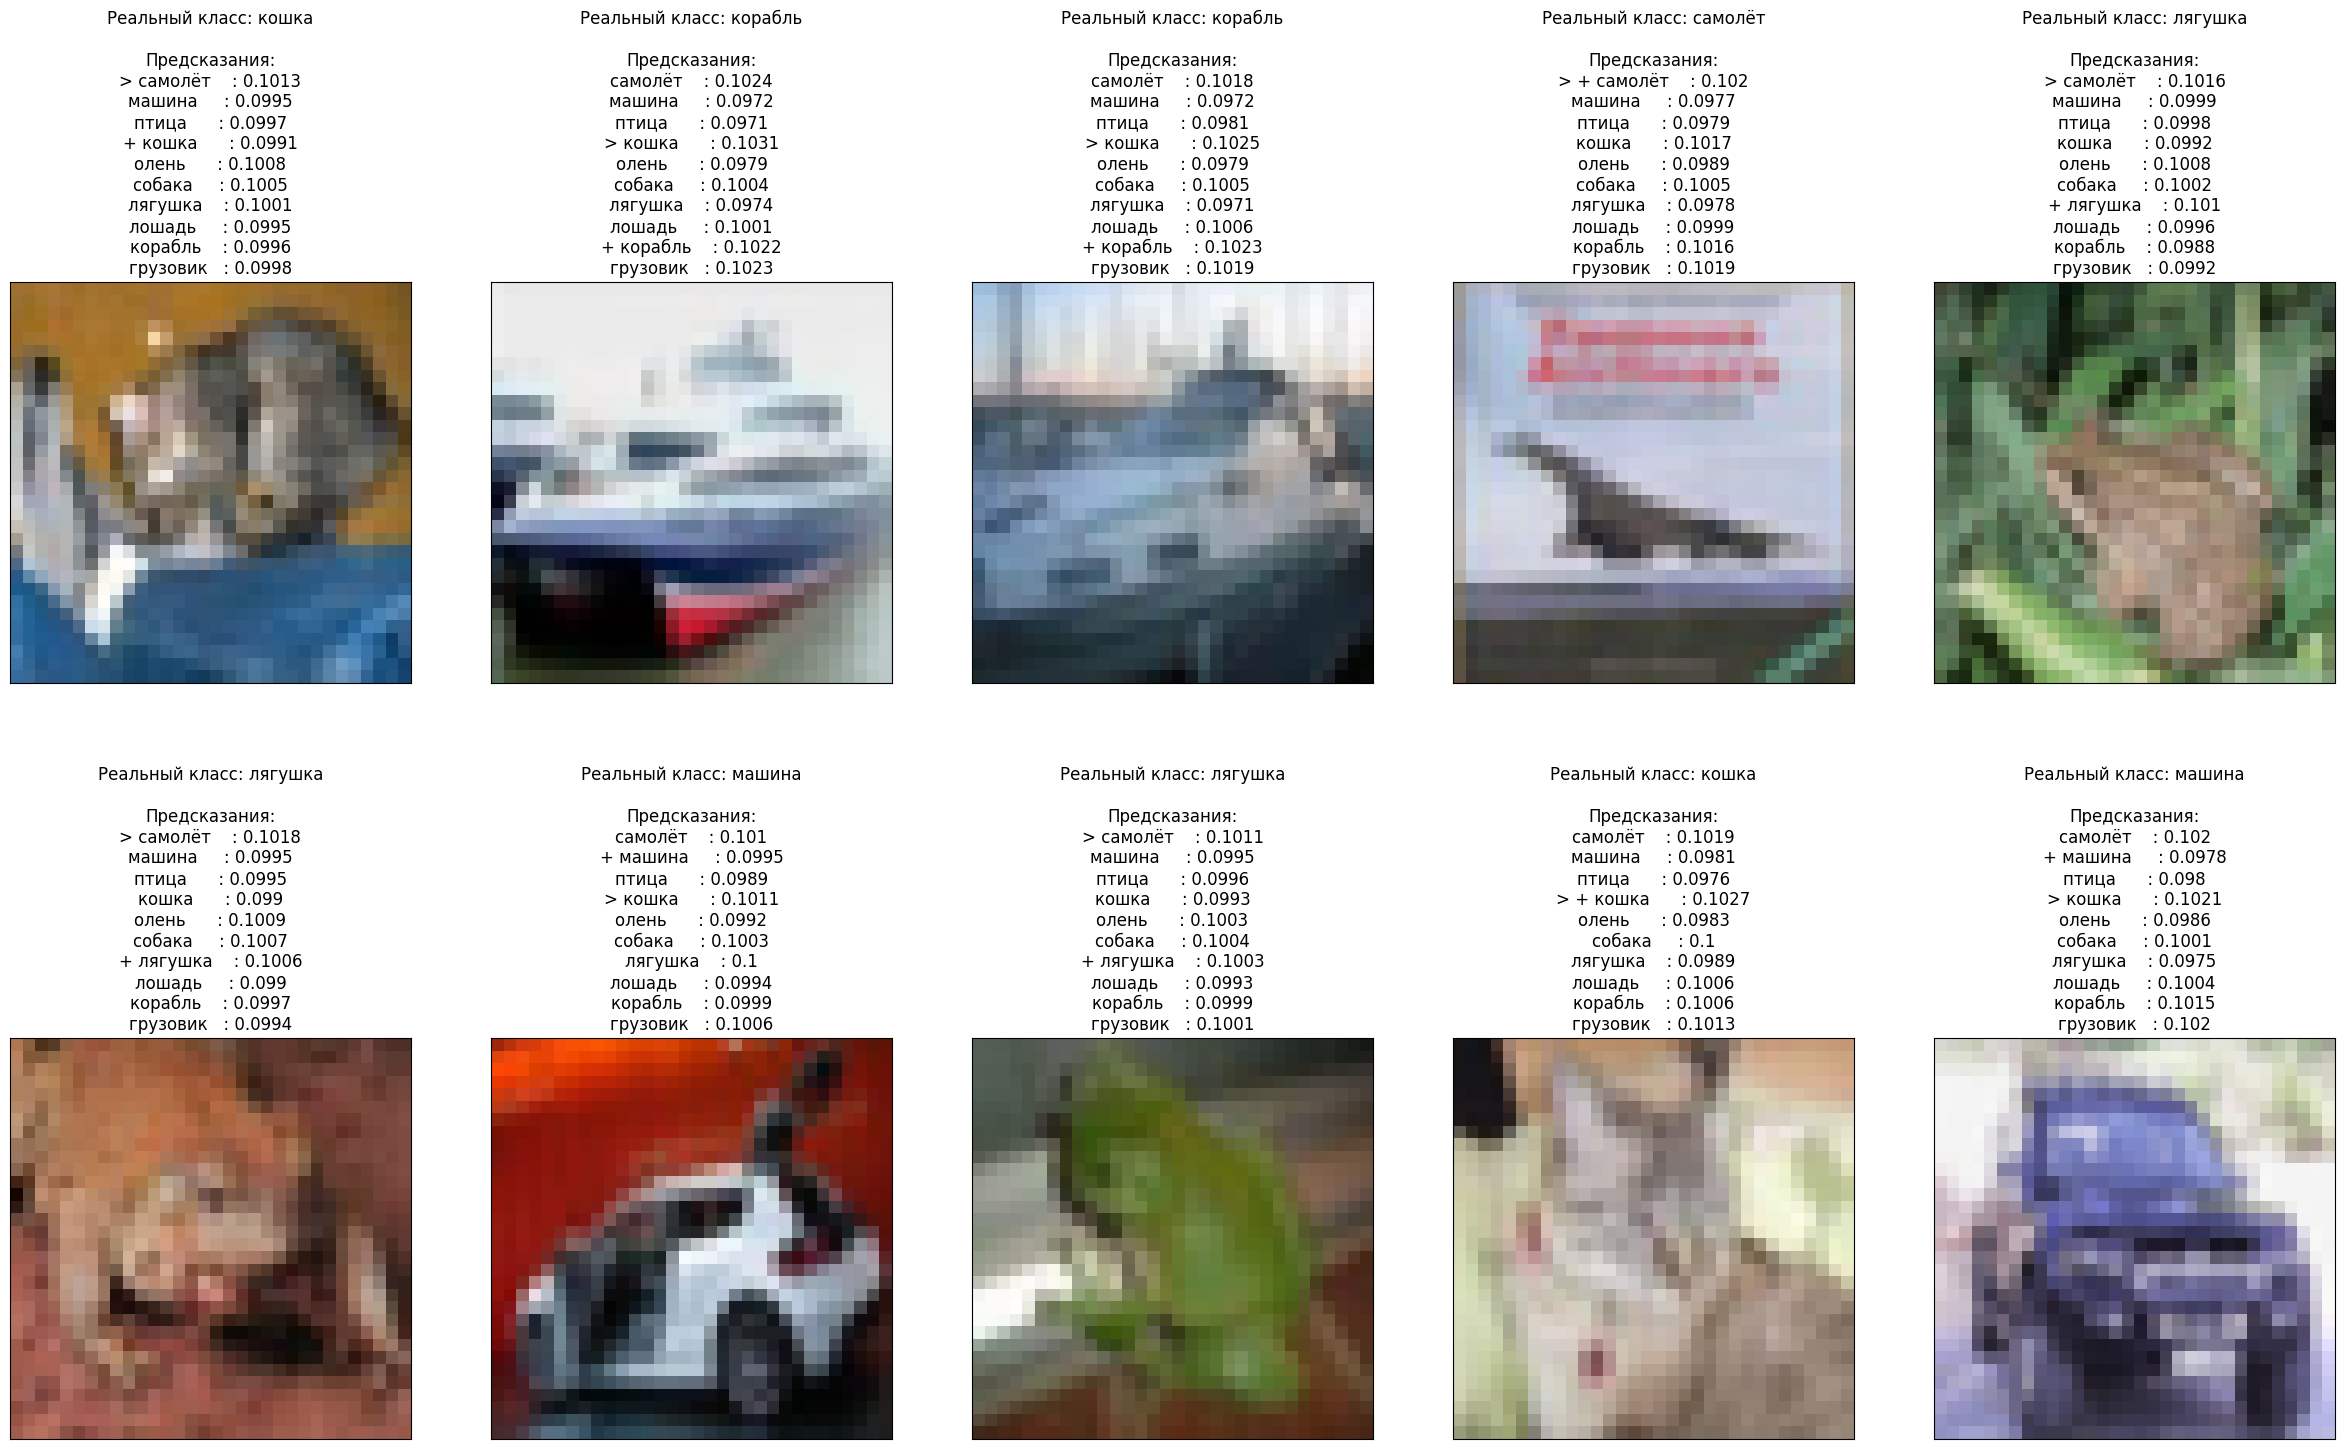

In [31]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки.

classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

def show_results(model, h=2, w=5):
    with torch.no_grad():
        batch_probs = model(x_val[:h*w].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(x_val[i])
            title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

show_results(model)

#### Задание.
Примените технологию residual connection для нейросети из задания № 2. 

1) Опишите архитектуру нейросети

2) Создайте экземпляр класса ResidualModel

3) Проведите обучение нейронной сети. Сделайте отображение величины ошибки для тренировочной и валидационной выборки нак графике в процесе вычислений (аналогично примеру выше). 

4) Отобразите результат классификации с указанием класса-результата и верного ответа для 10 случайных картинок тестовой выборки (аналогично примеру выше).
5) Сравните точность полученной модели с той, что была реализована в задании № 2.
   

т.к. в предыдущей работе использовался тот же датасет, что и тут, то был выбран cifar100

Архитектура
- Conv1: 3x3 свертка с 16 фильтрами
- ResidualBlock1: два 3x3 свертка с 16 фильтрами + skip connection
- ResidualBlock2: два 3x3 свертка с 32 фильтрами + skip connection с downsampling
- ResidualBlock3: два 3x3 свертка с 64 фильтрами + skip connection с downsampling
- Global Average Pooling
- Linear: 100 нейронов

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

download_dir = "./datasetcfr100"

trainset = torchvision.datasets.CIFAR100(root=download_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR100(root=download_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

In [5]:
class ResNetCIFAR100(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.in_channels = 16
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual blocks
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        
        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, 
                            stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
            
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

net = ResNetCIFAR100()

Алгоритм обучения без scheduler, присутствует риск переобучения

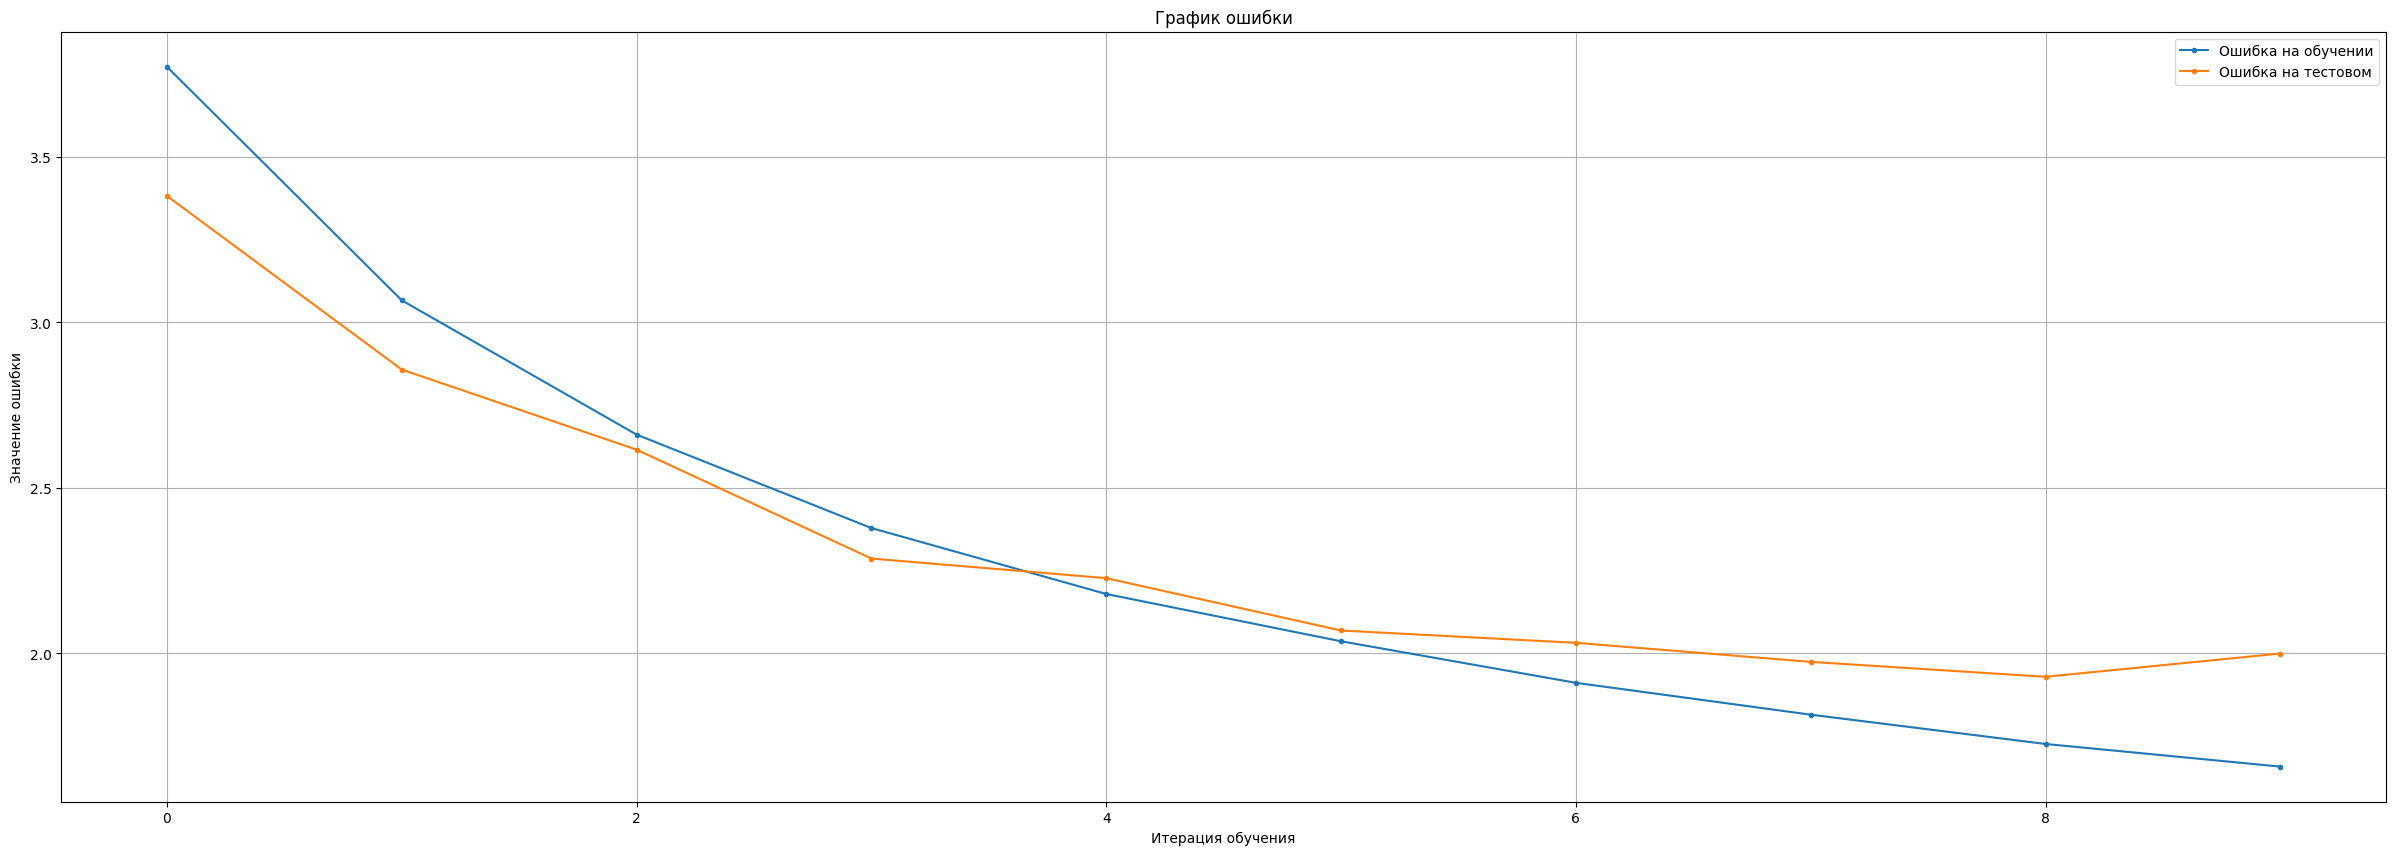

In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses = []
test_losses = []
accuracies = []

print("Starting training...")
for epoch in range(10):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Валидация
    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    scheduler.step()
    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    accuracies.append(100*correct/total)

    clear_output(True)
    fig, ax = plt.subplots(figsize=(30, 10))
    plt.title("График ошибки")
    plt.plot(train_losses, ".-", label="Ошибка на обучении")
    plt.plot(test_losses, ".-", label="Ошибка на тестовом")
    plt.xlabel("Итерация обучения")
    plt.ylabel("Значение ошибки")
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
image, label = testset[0]

net.eval()
with torch.no_grad():
    output = net(image.unsqueeze(0))
    _, predicted = torch.max(output, 1)

print(f"Predicted: {predicted.item()}, True: {label}")

Predicted: 49, True: 49


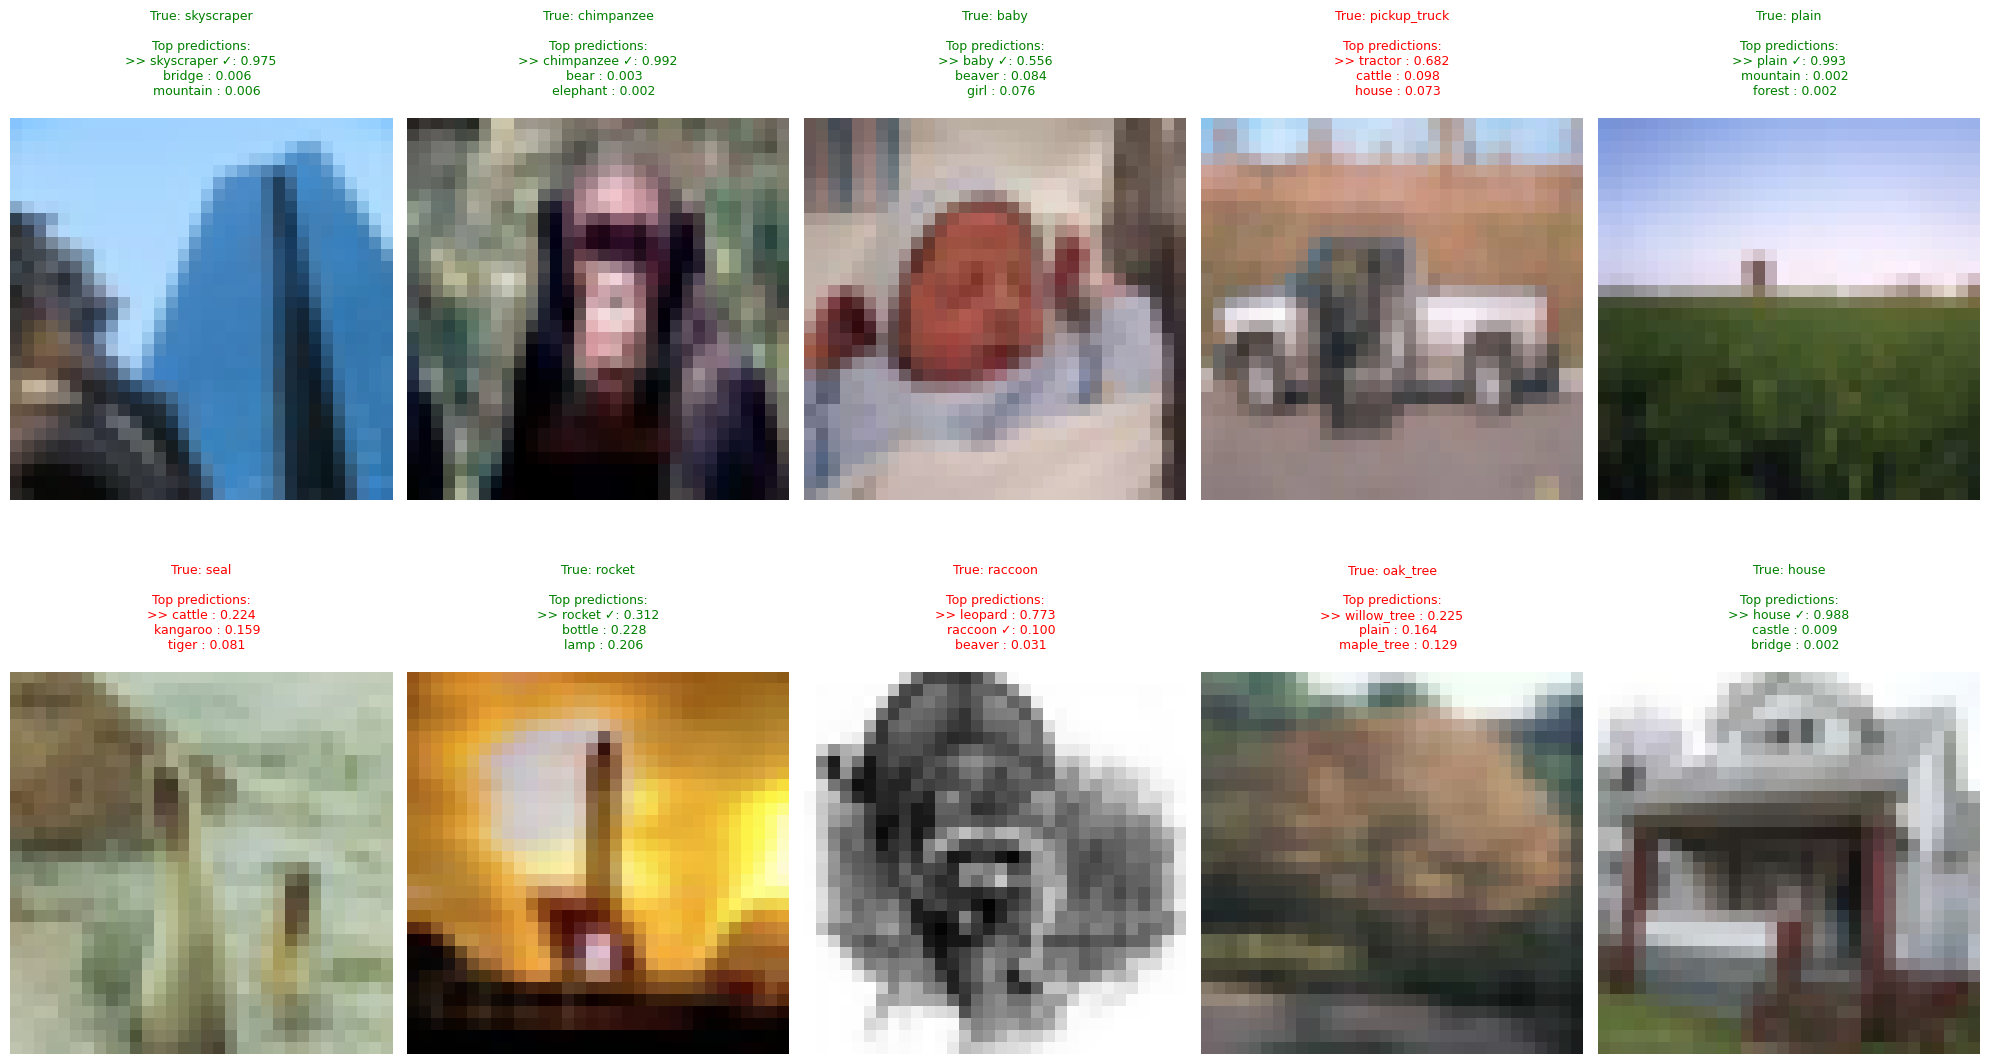

In [10]:
import numpy as np

def show_results_detailed(model, testset, h=2, w=5, top_k=3):
    classes = testset.classes
    
    # Выбираем случайные индексы
    indices = np.random.choice(len(testset), h*w, replace=False)
    
    # Подготавливаем данные
    images = torch.stack([testset[i][0] for i in indices])
    labels = [testset[i][1] for i in indices]
    
    # Получаем предсказания
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)
    
    # Создаем график
    fig, axes = plt.subplots(h, w, figsize=(20, 6*h))
    if h == 1:
        axes = [axes]
    if w == 1:
        axes = [[ax] for ax in axes]
    
    for i, (idx, ax) in enumerate(zip(indices, axes.flat)):
        # Оригинальное изображение
        original_img = testset.data[idx]
        ax.imshow(original_img)
        
        # Получаем топ-K предсказаний
        probs, indices_top = torch.topk(probabilities[i], top_k)
        pred_classes = indices_top.tolist()
        pred_probs = probs.tolist()
        
        true_class = labels[i]
        pred_class = predictions[i].item()
        
        # Формируем детальный заголовок
        color = 'green' if pred_class == true_class else 'red'
        title = f'True: {classes[true_class]}\n\nTop predictions:\n'
        
        for j, (class_idx, prob) in enumerate(zip(pred_classes, pred_probs)):
            marker = "✓" if class_idx == true_class else ""
            prefix = ">> " if j == 0 else "   "
            title += f'{prefix}{classes[class_idx]} {marker}: {prob:.3f}\n'
        
        ax.set_title(title, color=color, fontsize=9)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Использование расширенной версии
show_results_detailed(net, testset, top_k=3)

In [11]:
testset.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

Модель с ResidualBlock получилась точнее важнее на мой взгляд то что она гораздо быстрее смогла обучиться до такого состояния без заметного переобучения. В предыдущей же модели приходилось занижать LR иначе она быстро переобучалась